# Levy Distribution

* Foragers with no or limited prior knowledge of food show searching patterns that have special characteristics. 
* The patterns are different from what can be seen in Brownian motion, the random walk by particles diffusing in a liquid. 
* Foragers sometimes take long paths in just one direction. This strategy is found to be the key to the foragers’ success in finding food rapidly in an unknown environment.

Power law probability distribution defined by
$$ p(l) \propto l^{-\mu}$$
where, $l$ represents flight lengths and $\mu$ is scaling parameter <br>

* A more general Lévy distribution can be classified as a power-law distribution where the scaling parameter, μ, lies in the range 1 < μ ≤ 3. 
* Scaling parameter μ ≤ 1 can not be normalized, and power-law distribution when μ ≥ 3 turns into a Gaussian distribution. 
* Thus, a Lévy flight consists of flight lengths that obey the power-law distribution with 1 < μ ≤ 3.
* $p$ tends to infinty as $l$ tends to zero. So there would be a low limit on $l$.

<br>
The concept of a normalizing constant arises in probability theory and a variety of other areas of mathematics. The normalizing constant is used to reduce any probability function to a probability density function with total probability of one. [https://en.wikipedia.org/wiki/Normalizing_constant]

$$ p(l) = C l^{-\mu} $$
where C is normalization constant. From definition of normalization constant,
$$ \int_{l_{min}}^{\infty} p(l)dl = 1$$
$$ C = (\mu - 1) l_{min}^{\mu -1} $$
$p(l)$ in final form
$$ p(l) = \frac{\mu -1}{l_{\min}} \left(\frac{l}{l_{min}} \right)^{-\mu} $$

## Generating samples following Levy distribution
The inversion method is applied to generate samples of $l$. We will start with evaluation of CDF 
$$ F_L(l) = \int_{l_{min}}^{l} p(x)dx $$ 
<br>
$$ = \int_{l_{min}}^{l} \frac{\mu -1}{l_{\min}} \left(\frac{x}{l_{min}} \right)^{-\mu} dx $$
<br>
$$ = 1 - \left(\frac{l}{l_{min}}\right)^{1-\mu}$$
we know that $F_L(l)$ is the probablity, area under probability distribution curve.
$$ 0 \leq F_L(l) \le 1 $$
Let $r = F_L(l)$. After inversion,
$$ l = l_{min} \left( 1 - r \right)^{\frac{1}{1-\mu}} $$

In [58]:
%%capture
%matplotlib inline
#%matplotlib qt

import math
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
flen_min = 1
flen_max = 10
flen = np.arange(flen_min, flen_max, 0.1)

mu = np.arange(1.5, 3.5, 0.5)
p = []
for m in mu:
    p_var = []
    for l in flen:
        var = (m-1)/flen_min*(l/flen_min)**-m
        p_var.append(var)
    p.append(p_var)
print(len(p), list(mu))

4 [1.5, 2.0, 2.5, 3.0]


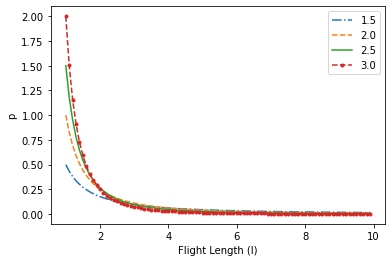

In [3]:
plt.plot(flen, p[0], '-.', label='1.5')
plt.plot(flen, p[1], '--', label='2.0')
plt.plot(flen, p[2], label='2.5')
plt.plot(flen, p[3], '--.', label='3.0')
plt.xlabel('Flight Length (l)')
plt.ylabel('p')
plt.legend()

## Levy Flight Simulation

### Rules of the World
* Predator follows Levy flight distribution. Preys are static and generated randomly within the grid area defined.
* Predator has a maximum range of the shape of a circle.
* Circle center is the origin of predator.
* At edge of circle, the selection of angle is limited to inside area. 
* Predator has a minimum range under which the capture of prey is guranteed, $l_{min}$
* Even if the prey lies anywhere near to flight path of predator, it will be captured. The capture of prey is not limited to end points.

Shortest distance between a point to a line
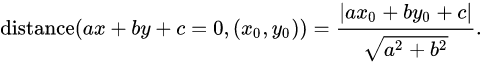

Point on the line nearest to the above point
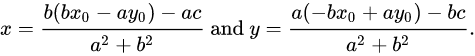

In [4]:
def proximity_sensor(Tx, Ty, xi, yi, l_min):
    l_prox = 0
    tx_ctf = 0
    ty_ctf = 0
    ctf = 0
    for tx, ty in zip(Tx, Ty):
        l_prox = ((tx-xi)**2 + (ty-yi)**2)**0.5
        if l_prox <= l_min:
            ctf = 1
            tx_ctf = tx
            ty_ctf = ty
            break
    return ctf, tx_ctf, ty_ctf

def proximity_sensor_path(Tx, Ty, xi, yi, xf, yf, l_min):
    tx_ctf = 0
    ty_ctf = 0
    x_path = 0
    y_path = 0
    ctf = 0
    a = -(yf-yi)/(xf-xi)
    b = 1
    c = xi*(yf-yi)/(xf-xi) - yi
    xmax = max(xi, xf)
    xmin = min(xi, xf)
    ymax = max(yi, yf)
    ymin = min(yi, yf)
    for tx, ty in zip(Tx, Ty):
        l_prox = abs(a*tx + b*ty + c)/(a**2 + b**2)**0.5
        x_path = (b*(b*tx - a*ty) - a*c)/(a**2 + b**2)
        y_path = (a*(-b*tx + a*ty) - b*c)/(a**2 + b**2)
        if (l_prox <= l_min) and (x_path <= xmax) and (x_path >= xmin) and (y_path <= ymax) and (y_path >= ymin):
            ctf = 1
            tx_ctf = tx
            ty_ctf = ty
            break
    return ctf, x_path, y_path, tx_ctf, ty_ctf

[922, 479, 898, 60, 133, 243, 802, 633, 505, 517]
[311, 547, 752, 804, 961, 32, 688, 304, 946, 171]
Success with n = 774
Captured Prey at: 479 547


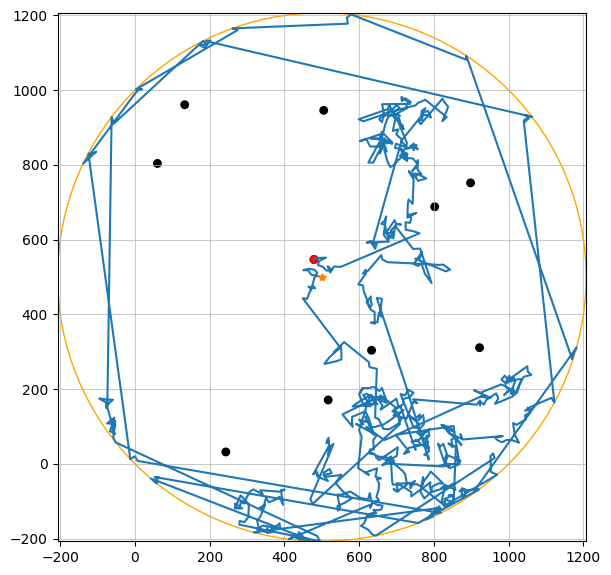

In [5]:
# Intial Conditions
l_min = 10
mu = 2.5
N = 10000

# grid size
R = 1000
C = 1000

# coordinate of prey on the grid
num_prey = 10
Tx = []
Ty = []

for i in range(num_prey):
    Tx.append(random.randint(0, R))
    Ty.append(random.randint(0, C))
print(Tx)
print(Ty)
# capture the flag
ctf = 0 

# initial location of predator
xi = int(R/2)
yi = int(C/2)

# angular range of predator
A = 2*math.pi

# initialization of temp variables
l = []
X = [xi]
Y = [yi]
n = 1
l_prox = 0

predator_range = (R**2 + C**2)**0.5/2 # circle of some radius from initial point
xmax = xi + predator_range
ymax = yi + predator_range
xmin = xi - predator_range
ymin = yi - predator_range
    
while (1):
    ctf, Tx_ctf, Ty_ctf = proximity_sensor(Tx, Ty, xi, yi, l_min)
    if (ctf == 1):
        X.append(Tx_ctf)
        Y.append(Ty_ctf)
        n += 1
        print("Success with n =", n)
        print("Captured Prey at:", Tx_ctf, Ty_ctf)
        break
    
    if (n == N):
        print("Simulation stopped as max. n reached")
        break
    
    # generating parameters, length & direction, as per Levy Distribution
    r = random.random()
    theta = random.uniform(0, A)
    l_var = l_min*(1-r)**(1/(1-mu))
    xf = xi + l_var*math.cos(theta)
    yf = yi + l_var*math.sin(theta)
        
    l_origin = ((xf-int(R/2))**2 + (yf-int(C/2))**2)**0.5
   
    if (l_origin <= predator_range):
        ctf, x_path, y_path, Tx_ctf, Ty_ctf  = proximity_sensor_path(Tx, Ty, xi, yi, xf, yf, l_min)
        if (ctf == 1):
            X.append(x_path)
            Y.append(y_path)
            X.append(Tx_ctf)
            Y.append(Ty_ctf)
            n += 2
            print("Success with n =", n)
            print("Captured Prey at:", Tx_ctf, Ty_ctf)
            break
        X.append(xf)
        Y.append(yf)
        xi = xf
        yi = yf
        n += 1
    else:
        xf = predator_range*math.cos(theta) + int(R/2)
        yf = predator_range*math.sin(theta) + int(R/2)
        ctf, x_path, y_path, Tx_ctf, Ty_ctf  = proximity_sensor_path(Tx, Ty, xi, yi, xf, yf, l_min)
        if (ctf == 1):
            X.append(x_path)
            Y.append(y_path)
            X.append(Tx_ctf)
            Y.append(Ty_ctf)
            n += 2
            print("Success with n =", n)
            print("Captured Prey at:", Tx_ctf, Ty_ctf)
            break
            
        X.append(xf)
        Y.append(yf)
        xi = xf
        yi = yf
        
        r = random.random()
        # theta to be selected so that the predator remains inside the circle
        if (theta >= 0) and (theta <= 0.5*math.pi):
            theta = random.uniform(math.pi - (0.5*math.pi-theta), 1.5*math.pi + theta)
        elif (theta >= 0.5*math.pi) and (theta <= math.pi):
            theta = random.uniform(1.5*math.pi - (1*math.pi-theta), 2*math.pi + theta - 0.5*math.pi)
        elif (theta >= math.pi) and (theta <= 1.5*math.pi):
            theta = random.uniform(0*math.pi - (1.5*math.pi-theta), 0.5*math.pi + theta - math.pi)
        else:
            theta = random.uniform(0.5*math.pi - (2*math.pi-theta), math.pi + theta - 1.5*math.pi)
        
        l_var = l_min*(1-r)**(1/(1-mu))
        xf = xi + l_var*math.cos(theta)
        yf = yi + l_var*math.sin(theta)
        
        ctf, x_path, y_path, Tx_ctf, Ty_ctf  = proximity_sensor_path(Tx, Ty, xi, yi, xf, yf, l_min)
        if (ctf == 1):
            X.append(x_path)
            Y.append(y_path)
            X.append(Tx_ctf)
            Y.append(Ty_ctf)
            n += 2
            print("Success with n =", n)
            print("Captured Prey at:", Tx_ctf, Ty_ctf)
            break
            
        X.append(xf)
        Y.append(yf)
        xi = xf
        yi = yf
        n += 2

fig, ax = plt.subplots()
fig.set_dpi(100)
fig.set_size_inches(7, 7)
plt.grid(linewidth=0.5)

ax = plt.axes(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.grid(linewidth=0.5)
plt.gca().set_aspect("equal")

plt.plot(X, Y)
plt.plot(int(R/2), int(C/2), '*')
ax.add_patch(plt.Circle((int(R/2), int(R/2)), predator_range, edgecolor='orange', facecolor='white'))
for tx, ty in zip(Tx, Ty):
    ax.add_patch(plt.Circle((tx, ty), l_min, color='black'))
    
captured_target = plt.Circle((Tx_ctf, Ty_ctf), l_min, color='r')
ax.add_patch(captured_target)
plt.show()

774


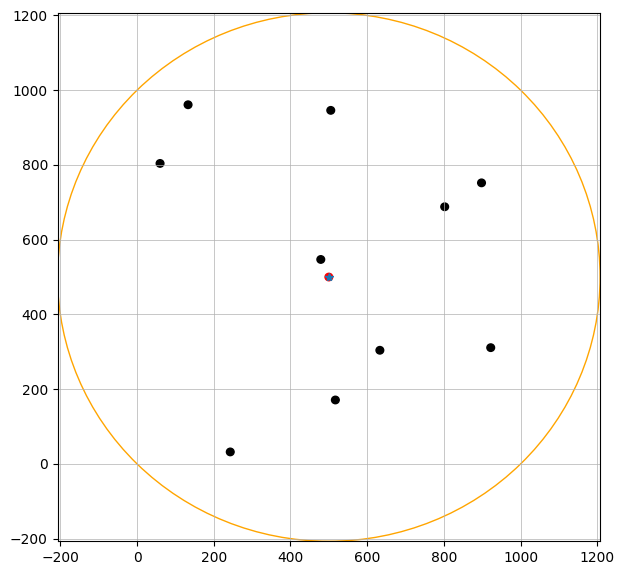

In [61]:
# Animation Function
fig_anim = plt.figure()
fig_anim.set_dpi(100)
fig_anim.set_size_inches(7, 7)
plt.gca().set_aspect("equal")

ax = plt.axes(xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.grid(linewidth=0.5)

plt.plot(int(R/2), int(C/2), '*')
ax.add_patch(plt.Circle((int(R/2), int(R/2)), predator_range, edgecolor='orange', facecolor='white'))
for tx, ty in zip(Tx, Ty):
    ax.add_patch(plt.Circle((tx, ty), l_min, color='black'))
    
hunter = plt.Circle((int(R/2), int(C/2)), l_min, color='r')
    
path, = ax.plot([], [], 'b')

path_x = []
path_y = []

def path_cord(x, y):
    path_x.append(x)
    path_y.append(y)
    return path_x, path_y

def init():
    path.set_data([], [])
    hunter.center = (int(R/2), int(C/2))    
    ax.add_patch(hunter)
    return path, hunter,

def animate(i):
    x = X[i]
    y = Y[i]
    path.set_data(*path_cord(x, y))
    hunter.center = (x, y)    
    ax.add_patch(hunter)
    return path, hunter,

print(len(X))
anim = animation.FuncAnimation(fig_anim, animate, 
                               init_func=init,
                               frames=len(X)-1,
                               interval=100,
                               blit=True, repeat=False)


In [64]:
HTML(anim.to_html5_video())

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '700x700', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpz8s9ylh1/temp.m4v']' returned non-zero exit status 255.

In [63]:
#anim.save('levy_motion.mp4') 